In [38]:
from thefuzz import fuzz
import matplotlib.pyplot as plt
from collections import Counter
import json
import csv

In [28]:
# test the fuzz function
# fuzz.ratio("typological classification", "soil classification") #???
fuzz.ratio("water", "wasser")

73

case sensitive match:
- match json: 10368 lines
- mis_keys json: 44014 lines


case insentive match
- 13394
- 41902

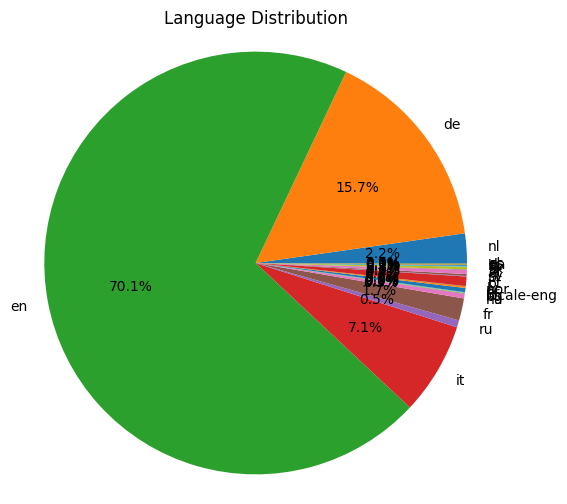

In [10]:
# Calculate the count of each languages in the missed keywords
with open("mis_keys.json", "r") as f:
    keys = json.load(f)

language_counts = Counter(lang for _, lang in keys)

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(language_counts.values(), labels=language_counts.keys(), autopct='%1.1f%%')
plt.title('Language Distribution')
plt.axis('equal')
plt.show()

In [12]:
# analyze english label:
en_keys = [item[0].lower() for item in keys if item[1] == "en"] # lower case
label_counts = Counter(en_keys)

lower_keys = [item.lower() for item in en_keys]
print(len(set(lower_keys)))


sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

print("Label Counts (sorted from high to low):")
for label, count in sorted_labels:
    print(f"{label}: {count}")

795
Label Counts (sorted from high to low):
soil types: 457
ejp country survey: 176
water: 163
wapor: 159
wapor_2: 140
africa and near east: 138
wapor_2_subnational: 119
esdac: 107
land use: 97
soil profiles: 94
digital soil mapping: 92
monthly: 89
world: 87
climate: 72
water accounting: 71
autogenerated: 69
land suitability: 68
opendata: 67
land: 66
dekadal: 61
geology: 57
adb: 52
tag_soil: 49
ph: 47
rwanda: 44
.all subjects: 43
india: 41
texture: 41
ethiopia: 40
electrical conductivity: 39
crops: 38
el salvador: 38
sudan: 36
groundwater: 35
calcium: 35
landscape: 34
uganda: 34
aquaculture: 33
karnataka: 33
krishna river basin: 33
salinity: 33
annual: 33
tunisia: 31
drainage: 31
indonesia: 30
egypt: 30
hih_soil: 28
evapotranspiration: 28
kenya: 28
agriculture: 28
harmonized world soil database: 27
philippines: 27
niger: 27
fish farming: 27
fishery: 27
tag_gislab: 27
climafrica: 26
tag_climafrica: 26
lebanon: 26
pakistan: 26
land resources: 25
indus plain: 25
nigeria: 24
africover: 24


In [17]:
with open("match.json", "r") as f:
    match = json.load(f)

matched_label = [item["label"] for item in match]
print("number of matched labels:", len(set(matched_label)))
matched_id = [item["record_identifier"] for item in match]
print("number of records found matched labels: ", len(set(matched_id)))

number of matched labels: 71
number of records found matched labels:  1767


In [16]:
with open("concepts.json", "r") as f:
    concepts = json.load(f)
matched_identifiers = [item["concept_identifier"] for item in match]
not_used_concepts = [item["identifier"] for item in concepts if item["identifier"] not in matched_identifiers]
for i in not_used_concepts:
    print(i, "\n")

https://soilwise-he.github.io/soil-health#AggregateStability 

https://soilwise-he.github.io/soil-health#AgriculturalAreaUnderSevereErosion 

https://soilwise-he.github.io/soil-health#ClimateResilience 

https://soilwise-he.github.io/soil-health#ComplexSoilParameters 

https://soilwise-he.github.io/soil-health#ContaminatedSites 

https://soilwise-he.github.io/soil-health#CulturalServices 

https://soilwise-he.github.io/soil-health#DeadOrganicComponents 

https://soilwise-he.github.io/soil-health#DynamicSoilParameters 

https://soilwise-he.github.io/soil-health#Entisols 

https://soilwise-he.github.io/soil-health#EnvironmentalQuality 

https://soilwise-he.github.io/soil-health#ErosionByWater 

https://soilwise-he.github.io/soil-health#ExclusionCriteria 

n672e7055bfa745f2954bb0d09f550bd9b1 

https://soilwise-he.github.io/soil-health#ExtentOfOrganicSoils 

https://soilwise-he.github.io/soil-health#FacultativeParameters 

https://soilwise-he.github.io/soil-health#FoodProduction 

https://

In [37]:
# Test the Water issue:
# fixed: mistake in a loop, sub_flag and flag

from dotenv import load_dotenv

from rdflib import Graph

from thefuzz import fuzz
import json, os, psycopg2

load_dotenv()

def dbInit():
    return psycopg2.connect(
        host=os.environ.get("POSTGRES_HOST"),
        port=os.environ.get("POSTGRES_PORT"),
        dbname=os.environ.get("POSTGRES_DB"),
        user=os.environ.get("POSTGRES_USER"),
        password=os.environ.get("POSTGRES_PASSWORD")
    )  

def dbQuery(sql,params=(),hasoutput=True):
    dbconn = dbInit()
    try:
        cursor = dbconn.cursor()
        cursor.execute(sql,params)
        if hasoutput:
            return cursor.fetchall()
        else:
            dbconn.commit()
    except Exception as e:
        print(f"DB Error: {str(e)}, {sql}")
    finally:
        dbconn.close();

def turple2dict(rows): # transform a query result from turple to dict
    col_names = ['identifier', 'hash', 'uri', 'turtle']  
    return [dict(zip(col_names, row)) for row in rows]

def getTurtles(rdf):
    try:
        g = Graph()
        g.parse(data=rdf, format="turtle")
        return g
    except:
        return None


def rdfSearchKeys(g):
    # When there is syntex error in the rdf?
    # When keyword not found?
    try:
        query = '''
        PREFIX DCAT: <http://www.w3.org/ns/dcat#>
        SELECT ?keyword ?lang
        WHERE {
            ?s DCAT:keyword ?keyword .
            BIND(lang(?keyword) AS ?lang)
        }
        '''
        results = g.query(query)
        
        # Convert results to a list of lists (keyword, language)
        keywords = [[str(row[0]), str(row[1])] for row in results]
        return keywords
    
    except:
        print(f"Error in RDF parsing or query")
        return []


# To find the most matching subject (if exsists) by the labels
vague_match = []

def label_fuzzmatch(subs, keyword, threshold=80):
    
    key_value, key_lang = keyword
    best_match_subject = None
    
    flag = 0

    for sub in subs:
        subject_id = sub['identifier']
        labels = sub['labels']
        
        # Flatten labels: include all labels in 'en' and the specified language (if exists)
        all_labels = labels.get('en', [])  # Default to 'en' labels
        if key_lang in labels and key_lang != 'en':
            all_labels.extend(labels[key_lang])  # Add labels for the specified language
        
        sub_flag = 0
        # get the highest matched value of this sub
        for lab in all_labels:
            matched_ratio = fuzz.ratio(key_value.lower(), lab.lower()) # if case sensitive. fuzz.ratio ("water", "water") = 80, short words can have a low match score
            if matched_ratio > sub_flag:
                sub_flag = matched_ratio
        
        # get the highest matched subject and the matched value
        if sub_flag > flag:
            flag = sub_flag
            best_match_subject = subject_id

        
    # check if the matching value with the threshold
    if flag >= threshold:
        #print('find matched label:', key_value, best_match_subject, flag)
        if flag < 100:
            list = [keyword, best_match_subject, flag]
            if list not in vague_match:
                vague_match.append(list)
            # print(keyword, best_match_subject, "\n", "score:", flag)
            print()
        return best_match_subject
    else:
        return None


sql = '''
SELECT * FROM harvest.item_contain_keyword
'''
result = turple2dict(dbQuery(sql, hasoutput=True))
# for quick testing
# result = result[:500]


# get defined subjects
with open("concepts.json", "r") as f:
    subs = json.load(f)

matched_data = []
mismatched_keys = []

key_id_turtles = []

#label_fuzzmatch(subs, ["water", "nl"], threshold=80)

for res in result:
    turtle = res['turtle']
    graph = getTurtles(turtle)
    if graph is not None:
        key_id_turtles.append({"id": res["identifier"], "turtle": graph})



for item in key_id_turtles:
    keys = rdfSearchKeys(item["turtle"])
    # print("keywords found:", keys)
    
    subs_related = []

    # match the keys
    for key in keys:
        sub_key = label_fuzzmatch(subs, key, threshold = 80)
        if sub_key is not None:
            subs_related.append(sub_key)
        # else:
            # mismatched_keys.append(key)

    # get all the matched subject id
    unique_subs_related = list(set(subs_related))

    if len(unique_subs_related) > 0:
        for sub_id in unique_subs_related:
            # Find the corresponding subject by subject_id
            matched_subject = next((sub for sub in subs if sub['identifier'] == sub_id), None)
            if matched_subject:
                # insertMatch(res['identifier'], res['hash'], sub_id, matched_subject["labels"]["en"][0] )
                matched_data.append({
                    'record_identifier': res['identifier'],
                    'hash': res['hash'],
                    'concept_identifier': sub_id,
                    'label': matched_subject["labels"]["en"][0]
                })

#print(matched_data)
for i in vague_match:
    print(i)

Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_xsd_date at 0x7fa0f2b59ab0>
Traceback (most recent call last):
  File "/home/li422/repos/isric/metadata-augmentation/.venv/lib/python3.10/site-packages/rdflib/term.py", line 2163, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
  File "/home/li422/repos/isric/metadata-augmentation/.venv/lib/python3.10/site-packages/rdflib/xsd_datetime.py", line 592, in parse_xsd_date
    raise ValueError("XSD Date string must contain at least two dashes")
ValueError: XSD Date string must contain at least two dashes
Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_xsd_date at 0x7fa0f2b59ab0>
Traceback (most recent call last):
  File "/home/li422/repos/isric/metadata-augmentation/.venv/lib/python3.10/site-packages/rdflib/term.py", line 2163, in _castLexicalToPython
    return con

In [ ]:
sample_list = [
    [['soil', 'de'], "soilhealth_url", 87],
    [['bodem', 'nl'], "soilhealth_url", 43]
]


with open('output.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(sample_list)